# Discriminative Classification

### Preliminaries

- Goal 
  - Introduction to discriminative classification models
- Materials        
  - Mandatory
    - These lecture notes
  - Optional
    - Bishop pp. 213-220 
    - [T. Minka (2005), Discriminative models, not discriminative training](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Minka-2005-Discriminative-models-not-discriminative-training.pdf)

###  Challenge: difficult class-conditional data distribitions

Our task will be the same as in the preceding class on (generative) classification. But this time, the class-conditional data distributions look very non-Gaussian, yet the linear discriminative boundary looks easy enough:

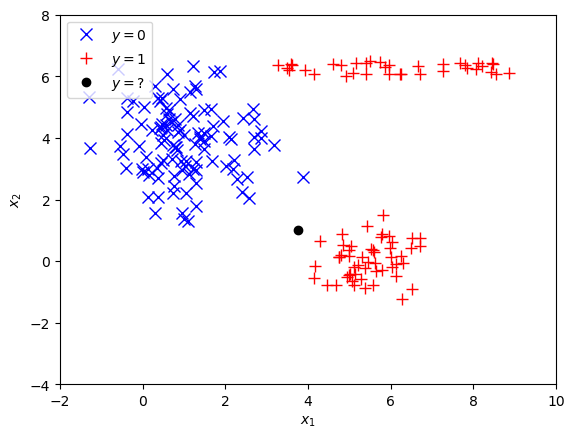

In [2]:
# Generate dataset {(x1,y1),...,(xN,yN)}
# x is a 2-d feature vector [x_1;x_2]
# y ∈ {false,true} is a binary class label
# p(x|y) is multi-modal (mixture of uniform and Gaussian distributions)
using PyPlot
include("./scripts/lesson8_helpers.jl")
N = 200
X, y = genDataset(N) # Generate data set, collect in matrix X and vector y
X_c1 = X[:,findall(.!y)]'; X_c2 = X[:,findall(y)]' # Split X based on class label
X_test = [3.75; 1.0] # Features of 'new' data point
function plotDataSet()
    plot(X_c1[:,1], X_c1[:,2], "bx", markersize=8)
    plot(X_c2[:,1], X_c2[:,2], "r+", markersize=8, fillstyle="none")
    plot(X_test[1], X_test[2], "ko")   
    xlabel(L"x_1"); ylabel(L"x_2"); 
    legend([L"y=0", L"y=1",L"y=?"], loc=2)
    xlim([-2;10]); ylim([-4, 8])
end
plotDataSet();

###  Main Idea of Discriminative Classification 

- Again, a data set is given by  $D = \{(x_1,y_1),\dotsc,(x_N,y_N)\}$ with $x_n \in \mathbb{R}^D$ and $y_n \in \mathcal{C}_k$, with $k=1,\ldots,K$.

-  Sometimes, the precise assumptions of the (multinomial-Gaussian) generative model $$p(x_n,y_n\in\mathcal{C}_k|\theta) =  \pi_k \cdot \mathcal{N}(x_n|\mu_k,\Sigma)$$ clearly do not match the data distribution.

- Here's an **IDEA**! Let's model the posterior $$p(y_n\in\mathcal{C}_k|x_n)$$  *directly*, without any assumptions on the class densities.

- Of course, this implies also that we build direct models for the **discrimination boundaries** 
  $$\log \frac{p(y_n\in\mathcal{C}_k|x_n)}{p(y_n\in\mathcal{C}_j|x_n)} \overset{!}{=} 0$$

### Bayesian Logistic Regression

- We will work this idea out for a 2-class problem. Assume a data set is given by  $D = \{(x_1,y_1),\dotsc,(x_N,y_N)\}$ with $x_n \in \mathbb{R}^D$ and $y_n \in \{0,1\}$.

##### Model Specification

- What model should we use for the posterior distribution $p(y_n \in \mathcal{C}_k|x_n)$?

- In Bayesian Logistic Regression, we take inspiration from the generative approach, where the **logistic function** (softmax for multi-class problems) "emerged" as the posterior. Here, we **choose** the familiar logistic structure with linear discrimination bounderies for the posterior class probability
$$
p(y_n =1 \,|\, x_n, w) = \sigma(w^T x_n) \,.
$$
where $$\sigma(a) = \frac{1}{1+e^{-a}}$$ is the _logistic_ function.

- <font color="red"> Add a plot of the logistic function</font>

- Adding the other class ($y_n=0$) leads to the following posterior class distribution:
$$\begin{align*}
p(y_n \,|\, x_n, w) &=  \sigma(w^T x_n)^{y_n} \left(1 - \sigma(w^T x_n)\right)^{(1-y_n)} \tag{B-4.89} \\
  &= \sigma\left( (2y_n-1) w^T x_n\right) \\
  &= \mathrm{Bernoulli}\left(y_n \,|\, \sigma(w^T x_n) \right) 
\end{align*}$$
  - Note that for the 2nd equality, we have made use of the fact that $\sigma(-a) = 1-\sigma(a)$.
  - (Each of these three models in B-4.89 are equivalent. We mention all three notational options since they all appear in the literature).  
  
- Note that in this model specification, we do not impose a Gaussian structure on the class features. In the discriminative approach, the parameters $w$ are **not** structured into $\{\mu,\Sigma,\pi \}$. This provides discriminative approach with more flexibility than the generative approach. 
  
- In *Bayesian* logistic regression, we add a **Gaussian prior on the weights**: 
$$\begin{align*}
p(w) = \mathcal{N}(w \,|\, m_0, S_0) \tag{B-4.140}
\end{align*}$$

##### <a id="#logistic-regression-posterior">Inference</a>

- The posterior for the weights follows by Bayes rule
$$\begin{align*}
\underbrace{p(w \,|\, D)}_{\text{posterior}} \propto  \underbrace{\prod_{n=1}^N \sigma\left( (2y_n-1) w^T x_n\right)}_{\text{likelihood}} \cdot \underbrace{\mathcal{N}(w \,|\, m_0, S_0)}_{\text{prior}} \tag{B-4.142}
\end{align*}$$

- In principle, Bayesian inference is done now. Unfortunately, the posterior is not Gaussian and the evidence $p(D)$ is also not analytically computable. (We will deal with this later).

##### Predictive distribution

- For a new data point $x_\bullet$, the predictive distribution for $y_\bullet$ is given by 
$$\begin{align*}
p(y_\bullet = 1 \mid x_\bullet, D) &= \int p(y_\bullet = 1 \,|\, x_\bullet, w) \, p(w\,|\, D) \,\mathrm{d}w \\
  &= \int \sigma(w^T x_\bullet) \, p(w\,|\, D) \,\mathrm{d}w \tag{B-4.145}
\end{align*}$$

- After substitution of $p(w | D)$ from B-4.142, we have an integral that is not solvable in closed-form. 

- Many methods have been developed to approximate the integrals for the predictive distribution and evidence. Here, we present the **Laplace approximation**, which is one of the simplest methods with broad applicability to Bayesian calculations.

### The Laplace Approximation

- The central idea of the Laplace approximation is to approximate a (possibly unnormalized) distribution $f(z)$ by a Gaussian distribution $q(z)$. 

- Note that $\log q(z)$ is a second order polynomial in $z$, so we will find the Gaussian by fitting a parabola to $\log f(z)$. 

- <font color="red"> Needs an image</font>

##### estimation of mean 

- The mean ($z_0$) of $q(z)$ is placed on the mode of $\log f(z)$, i.e., 

$$z_0 = \arg\max_z \log f(z) \tag{B-4.126}$$ 

##### estimation of variance

- Since the gradient $\nabla \left. f(z) \right|_{z=z_0}$ vanishes at the mode, we can (Taylor) expand $\log f(z)$ around $z=z_0$ as 
$$
\log f(z) \approx \log f(z_0) - \frac{1}{2} (z-z_0)^T A (z-z_0) \tag{B-4.131}
$$
where the [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix) $A$ is defined by
$$
A = - \nabla \nabla \left. \log f(z) \right|_{z=z_0} \tag{B-4.132}
$$

##### Laplace approximation

- After taking exponentials in eq. B-4.131, we obtain

$$
f(z) \approx f(z_0) \exp\left( - \frac{1}{2} (z-z_0)^T A (z-z_0)\right) 
$$

- We can now identify $q(z)$ as
$$
q(z) = \mathcal{N}\left( z\,|\,z_0, A^{-1}\right) \tag{B-4.134}
$$
with $z_0$ and $A$ defined by eqs. B-4.126 and B-4.132.


- <font color="red"> insert fig 4.14</font>

### Bayesian Logistic Regression with the Laplace Approximation

- Let's get back to the challenge of computing the predictive class distribution (B-4.145) for Bayesian logistic regression. We first work out the Gaussian Laplace approximation $q(w)$ to the [posterior weight distribution](#logistic-regression-posterior) 
$$\begin{align*}
\underbrace{p(w | D)}_{\text{posterior}} \propto  \underbrace{\prod_{n=1}^N \sigma\left( (2y_n-1) w^T x_n\right)}_{\text{likelihood}} \cdot \underbrace{\mathcal{N}(w \,|\, m_0, S_0)}_{\text{prior}} \tag{B-4.142}
\end{align*}$$

##### A Gausian Laplace approximation to the weights posterior 

- It is straightforward to compute the gradient and Hessian of $\log p(w | D)$:
$$\begin{align*}
\nabla_w \log p(w | D) &= S_0^{-1}\cdot \left(m_0-w\right) + \sum_n (2y_n-1) (1-\sigma_n) x_n \\
\nabla_w \nabla_w \log p(w | D) &= -S_0^{-1} - \sum_n \sigma_n (1-\sigma_n) x_n x_n^T \tag{B-4.143}
\end{align*}$$
where we used shorthand $\sigma_n$ for $\sigma\left( (2y_n-1) w^T x_n\right)$. 

- We can use the gradient to find the mode $w_{\text{MAP}}$ of $\log p(w|D)$ and use the Hessian to get the variance of $q(w)$, leading to a <a id="Laplace-posterior-logistic-regression">**Gaussian approximate weights posterior**</a>:

$$\begin{align*}
q(w) &= \mathcal{N}\left(w\,|\, w_{\text{MAP}}, S_N\right) \tag{B-4.144}\\
S_N^{-1} &= S_0^{-1} + \sum_n \sigma_n (1-\sigma_n) x_n x_n^T \tag{B-4.143}
\end{align*}$$


##### Using the Laplace weights posterior to evaluate the predictive distribution 

- In the analytically unsolveable expressions for evidence and the predictive distribution (estimating the class of a new observation), we proceed with using the Laplace approximation to the weights posterior. For a new observation $x_\bullet$, the class probability is now
$$\begin{align*}
p(y_\bullet = 1 \mid x_\bullet, D) &\approx \int p(y_\bullet = 1 \,|\, x_\bullet, w) \cdot \underbrace{q(w)}_{\text{Gaussian}} \,\mathrm{d}w \\
  &= \int \sigma(w^T x_\bullet) \cdot \mathcal{N}\left(w\,|\, w_{\text{MAP}}, S_N\right) \,\mathrm{d}w \tag{B-4.145}
\end{align*}$$

- This looks better but we need two more clever tricks to evaluate this expression. 
  1. First, note that $w$ only appears in inner products, so through substitution of $a:=w^T x_\bullet$, the expression simplifies to an integral over the scalar $a$ (see Bishop for derivation):
$$\begin{align*}
p(y_\bullet = 1 \mid x_\bullet, D) &\approx \int \sigma(a) \, \mathcal{N}\left(a\,|\, \mu_a, \Sigma_a\right) \,\mathrm{d}a \tag{B-4.151}\\
\mu_a  &= w^T_{\text{MAP}} x_\bullet \tag{B-4.149}\\
\Sigma_a &= x^T_\bullet S_N x_\bullet \tag{B-4.150}
\end{align*}$$
  1. Secondly, while the integral of the product of a logistic function with a Gaussian is not analytically solvable, the integral of the product of a Gaussian CDF (cumulative distribution function) with a Gaussian _does_ have a closed-form solution. Fortunately, 
$$\Phi(\lambda a) \approx \sigma(a)$$
with the Gaussian CDF $\Phi(x)= \frac{1}{\sqrt(2\pi)}\int_{-\infty}^{x}e^{-t^2/2}\mathrm{d}t$, $ \lambda^2= \pi / 8 $ and $\sigma(a) = 1/(1+e^{-a})$. Thus, substituting $\Phi(\lambda a)$ with $ \lambda^2= \pi / 8 $ for $\sigma(a)$ leads to 

$$\begin{align*}
p(y_\bullet = 1 \mid x_\bullet, D) &\approx \int \Phi(\lambda a) \, \mathcal{N}\left(a\,|\, \mu_a, \Sigma_a\right) \,\mathrm{d}a \\ &= \Phi\left( \frac{\mu_a}{\sqrt(\lambda^{-2} +\sigma_a^2)}\right) \tag{B-4.152}
\end{align*}$$

- We now have an approximate but **closed-form expression for the predictive class distribution for a new observation** with a Bayesian logistic regression model.  

- Note that, by [Eq.B-4.143](#Laplace-posterior-logistic-regression), the variance $S_N$ (and consequently $\sigma_a^2$) for the weight vector depends on the distribution of the training set. Large uncertainty about the weights (in areas with little training data and uninformative prior variance $S_0$) takes the posterior class probability eq. B-4.152 closer to $0.5$. Does that make sense?

- Apparently, the Laplace approximation leads to a closed-form solutions for Bayesian logistic regression (although admittedly, the derivation is no walk in the park). 

###  2. ML Estimation for Discriminative Classification
 
- TODO TODO ### <font color="red">Derive ML frmo Bayesian approach</font>

-  The conditional log-likelihood for discriminative classification is 

     $$
    \mathrm{L}(\theta) = \log \prod_n \prod_k {p(\mathcal{C}_k|x_n,\theta)}^{y_{nk}} 
     $$

     
- Computing the gradient $\nabla_{\theta_k} \mathrm{L}(\theta)$ (NB: revised text) leads to (for proof, see next slide) 

$$
\nabla_{\theta_k} \mathrm{L}(\theta) = \sum_n \Big( \underbrace{y_{nk}}_{\text{target}} - \underbrace{\frac{e^{\theta_k^T x_n}}{ \sum_j e^{\theta_j^T x_n}}}_{\text{prediction}} \Big)\cdot x_n 
$$

  
- Compare this to the gradient for _linear_ regression:

$$
\nabla_\theta \mathrm{L}(\theta) =  \sum_n \left(y_n - \theta^T x_n \right)  x_n
$$

- In both cases

$$
\nabla_\theta \mathrm{L} =  \sum_n \left( \text{target}_n - \text{prediction}_n \right) \cdot \text{input}_n 
$$

- The parameter vector $\theta$ for logistic regression can be estimated through iterative gradient-based adaptation. E.g. (with iteration index $i$),

$$
\hat{\theta}^{(i+1)} =  \hat{\theta}^{(i)} + \eta \cdot \left. \nabla_\theta   \mathrm{L}(\theta)  \right|_{\theta = \hat{\theta}^{(i)}}
$$

#### CODE EXAMPLE

Let us perform ML estimation of $w$ on the data set from the introduction. To allow an offset in the discrimination boundary, we add a constant 1 to the feature vector $x$. We only have to specify the (negative) log-likelihood and the gradient w.r.t. $w$. Then, we use an off-the-shelf optimisation library to minimize the negative log-likelihood.

We plot the resulting maximum likelihood discrimination boundary. For comparison we also plot the ML discrimination boundary obtained from the [code example in the generative Gaussian classifier lesson](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/classification/Generative-Classification.ipynb#code-generative-classification-example).

In [3]:
using Optim # Optimization library

y_1 = zeros(length(y))# class 1 indicator vector
y_1[findall(y)] .= 1
X_ext = vcat(X, ones(1, length(y))) # Extend X with a row of ones to allow an offset in the discrimination boundary

# Implement negative log-likelihood function
function negative_log_likelihood(θ::Vector)
    # Return negative log-likelihood: -L(θ)
    p_1 = 1.0 ./ (1.0 .+ exp.(-X_ext' * θ))   # P(C1|X,θ)
    return -sum(log.( (y_1 .* p_1) + ((1 .- y_1).*(1 .- p_1))) ) # negative log-likelihood
end

# Use Optim.jl optimiser to minimize the negative log-likelihood function w.r.t. θ
results = optimize(negative_log_likelihood, zeros(3), LBFGS())
θ = results.minimizer

# Plot the data set and ML discrimination boundary
plotDataSet()
p_1(x) = 1.0 ./ (1.0 .+ exp(-([x;1.]' * θ)))
boundary(x1) = -1 ./ θ[2] * (θ[1]*x1 .+ θ[3])
plot([-2.;10.], boundary([-2.; 10.]), "k-");
# # Also fit the generative Gaussian model from lesson 7 and plot the resulting discrimination boundary for comparison
generative_boundary = buildGenerativeDiscriminationBoundary(X, y)
plot([-2.;10.], generative_boundary([-2;10]), "k:");
legend([L"y=0";L"y=1";L"y=?";"Discr. boundary";"Gen. boundary"], loc=3);

Given $\hat{\theta}$, we can classify a new input $x_\bullet = [3.75, 1.0]^T$:

x_test = [3.75;1.0]
println("P(C1|x•,θ) = $(p_1(x_test))")

LoadError: syntax: "\" is not a unary operator

- The generative model gives a bad result because the feature distribution of one class is clearly non-Gaussian: the model does not fit the data well. 

- The discriminative approach does not suffer from this problem because it makes no assumptions about the feature distribition $p(x|y)$, it just estimates the conditional class distribution $p(y|x)$ directly.

### Recap Classification

<table>
<tr> <td></td><td style="text-align:center"><b>Generative</b></td> <td style="text-align:center"><b>Discriminative</b></td> </tr> 

<tr> <td>1</td><td>Like <b>density estimation</b>, model joint prob.
$$p(\mathcal{C}_k) p(x|\mathcal{C}_k) = \pi_k \mathcal{N}(\mu_k,\Sigma)$$</td> <td>Like (linear) <b>regression</b>, model conditional
$$p(\mathcal{C}_k|x,\theta)$$</td> </tr>

<tr> <td>2</td><td>Leads to <b>softmax</b> posterior class probability
$$ p(\mathcal{C}_k|x,\theta ) = e^{\theta_k^T x}/Z$$
with <b>structured</b> $\theta$</td> <td> <b>Choose</b> also softmax posterior class probability
$$ p(\mathcal{C}_k|x,\theta ) = e^{\theta_k^T x}/Z$$
but now with 'free' $\theta$</td> </tr>

<tr> <td>3</td><td>For Gaussian $p(x|\mathcal{C}_k)$ and multinomial priors,
$$\hat \theta_k  = \left[ {\begin{array}{c}
   { - \frac{1}{2} \mu_k^T \sigma^{-1} \mu_k  + \log \pi_k}  \\
   {\sigma^{-1} \mu_k }  \\
\end{array}} \right]$$
<b>in one shot</b>.</td> <td>Find $\hat\theta_k$ through gradient-based adaptation
$$\nabla_{\theta_k}\mathrm{L}(\theta) = \sum_n \Big( y_{nk} - \frac{e^{\theta_k^T x_n}}{\sum_{k^\prime} e^{\theta_{k^\prime}^T x_n}} \Big)\, x_n$$ </td> </tr>
</table>

### OPTIONAL MATERIALS



### 3. Application - Classify a new input

-  Discriminative model-based prediction for a new input $x_\bullet$ is easy, namely substitute the ML estimate in the model to get

$$
p(\mathcal{C}_k |\, x_\bullet,\hat\theta) = \frac{ \mathrm{exp}\left( \hat \theta_k^T x_\bullet \right) }{ \sum_{k^\prime} \mathrm{exp}\left(\hat \theta_{k^\prime}^T x_\bullet \right)} 
  \propto \mathrm{exp}\left(\hat \theta_k^T x_\bullet\right) 
$$

-  The contours of equal probability (**discriminant boundaries**) are lines (hyperplanes) in feature space given by
$$
\log \frac{{p(\mathcal{C}_k|x,\hat \theta )}}{{p(\mathcal{C}_j|x,\hat \theta )}} = \left( \hat{\theta}_{k} - \hat{\theta}_j\right) ^T x = 0
$$

###  2. <span style="color:red">(OPTIONAL)</span> Proof of Derivative of Log-likelihood for  Discriminative Classification


- The Log-likelihood is $
    \mathrm{L}(\theta) = \log \prod_n \prod_k {\underbrace{p(\mathcal{C}_k|x_n,\theta)}_{p_{nk}}}^{y_{nk}} = \sum_{n,k} y_{nk} \log p_{nk}$

     
- Use the fact that the softmax $\phi_k \equiv e^{a_k} / {\sum_j e^{a_j}}$ has analytical derivative:

$$ \begin{align*}
 \frac{\partial \phi_k}{\partial a_j} &= \frac{(\sum_j e^{a_j})e^{a_k}\delta_{kj}-e^{a_j}e^{a_k}}{(\sum_j e^{a_j})^2} = \frac{e^{a_k}}{\sum_j e^{a_j}}\delta_{kj} - \frac{e^{a_j}}{\sum_j e^{a_j}} \frac{e^{a_k}}{\sum_j e^{a_j}}\\
     &= \phi_k \cdot(\delta_{kj}-\phi_j)
 \end{align*}$$

<!---
%    -  Again we try to minimize the cross-entropy ($\sum_{nk} y_{nk} \log \frac{y_{nk}}{p_{nk}}$) between the data `targets' $t_{nk}$ and the model outputs $p_{nk}$.
--->

 -  Take the derivative of $\mathrm{L}(\theta)$ (or: how to spend a hour ...)
$$\begin{align*} 
\nabla_{\theta_j} \mathrm{L}(\theta) &= \sum_{n,k} \frac{\partial \mathrm{L}_{nk}}{\partial p_{nk}} \cdot\frac{\partial p_{nk}}{\partial a_{nj}}\cdot\frac{\partial a_{nj}}{\partial \theta_j} \\
  &= \sum_{n,k} \frac{y_{nk}}{p_{nk}} \cdot p_{nk} (\delta_{kj}-p_{nj}) \cdot x_n \\
  &= \sum_n \Big( y_{nj} (1-p_{nj}) -\sum_{k\neq j} y_{nk} p_{nj} \Big) \cdot x_n \\
  &= \sum_n \left( y_{nj} - p_{nj} \right)\cdot x_n \\
  &= \sum_n \Big( \underbrace{y_{nj}}_{\text{target}} - \underbrace{\frac{e^{\theta_j^T x_n}}{\sum_{j^\prime} e^{\theta_{j^\prime}^T x_n}}}_{\text{prediction}} \Big)\cdot x_n 
\end{align*}$$

### Bayesian Evidence Estimation with the Laplace Approximation

In [6]:
open("../../../styles/aipstyle.html") do f
    display("text/html", read(f,String))
end

<!--
This HTML file contains custom styles and some javascript.
Include it a Jupyter notebook for improved rendering.
-->

<!-- Fonts -->
 
 
 
 
 

<!-- Custom style -->


<!-- MathJax styling -->